In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2

from tqdm import tqdm
from scipy.interpolate import interpn


# 1. Bilateral filtering

In [6]:
img_bedtable_amb = './data/my_img/ambient1.jpg'
img_bedtable_flash = './data/my_img/flash1.jpg'

img_bedtable_amb = cv2.imread(img_bedtable_amb,-1)[:,:,::-1]
img_bedtable_flash = cv2.imread(img_bedtable_flash,-1)[:,:,::-1]

print(img_bedtable_amb.min(), img_bedtable_amb.max())
print(img_bedtable_flash.min(), img_bedtable_flash.max())

# normalize lamp images
img_lamp_amb_norm = img_bedtable_amb / 255
img_lamp_flash_norm = img_bedtable_flash / 255

0 109
0 255


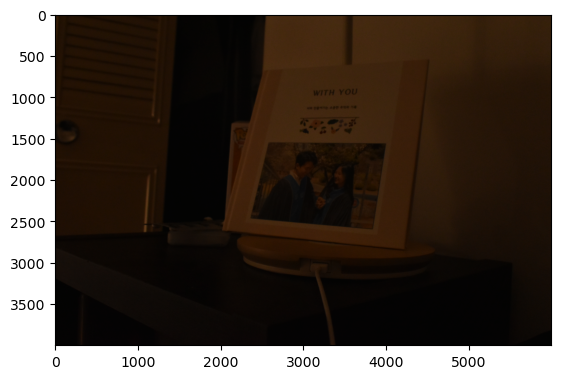

In [7]:
plt.imshow(img_lamp_amb_norm)

## Implement bilateral filtering

In [8]:
def piecewise_bilateral(img1, img2, i_j, sigma_r, sigma_s, num_segments=255, kernel_size=(3, 3)):
    """
    Perform Piecewise Bilateral filtering on an image.
    
    Parameters:
        img1, img2: Input images
        i_j: Array of intensity values
        sigma_r, sigma_s: Standard deviations for the range and spatial Gaussian filters
        num_segments: Number of segments for the bilateral filter (default is 255)
        kernel_size: Size of the Gaussian kernel (default is (3, 3))
        
    Returns:
        J: Final denoised image
    """
    
    # Initialize list to store filtered images for each segment
    filtered_images = []
    
    # Loop through each segment to apply the bilateral filter
    for j in tqdm(range(num_segments + 1)):
        # Calculate range Gaussian filter
        G_j = (1 / (sigma_r * np.sqrt(2 * np.pi))) * np.exp(-1 / (2 * sigma_r ** 2) * (img2 - i_j[j]) ** 2)
        
        # Calculate normalization factor
        K_j = cv2.GaussianBlur(G_j, kernel_size, sigmaX=sigma_s, sigmaY=sigma_s)
        
        # Multiply range Gaussian filter with the input image
        H_j = np.multiply(G_j, img1)
        
        # Apply Gaussian blur to H_j
        H_star_j = cv2.GaussianBlur(H_j, kernel_size, sigmaX=sigma_s, sigmaY=sigma_s)
        
        # Calculate the filtered image for the current segment
        J_j = H_star_j / K_j
        J_j[K_j == 0] = 1  # Handle cases where the denominator is zero
        
        # Append the filtered image to the list
        filtered_images.append(J_j)
    
    # Convert the list of filtered images to a NumPy array
    filtered_images = np.array(filtered_images)
    
    # Generate grid points for interpolation
    points_rows = np.arange(img1.shape[0])
    points_cols = np.arange(img1.shape[1])
    
    # Initialize list to store points for interpolation
    points_needed = [[img1[i, j], i, j] for i in range(img1.shape[0]) for j in range(img1.shape[1])]
    
    # Perform interpolation to generate the final denoised image
    J = interpn([i_j, points_rows, points_cols], filtered_images, points_needed)
    J = J.reshape(img1.shape)
    
    return J


In [26]:
# Set hyperparameters for bilateral filtering
lambda_val = 0.01
sigma_s = 32
sigma_r = 0.25

# Calculate minimum and maximum intensity values for the ambient image
min_intensity = np.min(img_lamp_amb_norm) - lambda_val
max_intensity = np.max(img_lamp_amb_norm) + lambda_val

# Calculate the number of segments for the bilateral filter
num_segments = np.ceil((max_intensity - min_intensity) / sigma_r).astype('int')

# Generate array of intensity values for each segment
i_j_values = [min_intensity + j * (max_intensity - min_intensity) / num_segments for j in range(num_segments + 1)]

# Set the kernel size for the Gaussian blur
kernel_size = [11, 11]

# Initialize an empty array to store the filtered channels
A_base = np.zeros_like(img_lamp_amb_norm)

# Apply Piecewise Bilateral filtering to each color channel (R, G, B)
for channel in range(3):
    A_base[:, :, channel] = piecewise_bilateral(
        img_lamp_amb_norm[:, :, channel], 
        img_lamp_amb_norm[:, :, channel], 
        i_j_values, 
        sigma_r, 
        sigma_s, 
        num_segments, 
        kernel_size
    )

#Save the filtered image into rgb format
# plt.imsave('outputs/A_base_{}.png'.format(sigma_r), A_base)
# cv2.imwrite('outputs/A_base_{}.png'.format(sigma_r), A_base * 255)

100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


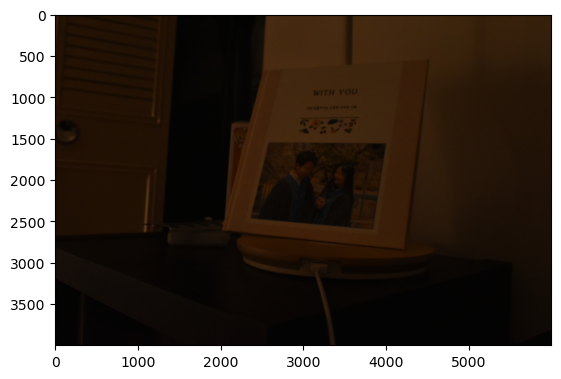

In [27]:
plt.imshow(np.clip(A_base, 0,1))

0.0 0.12863353534288102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


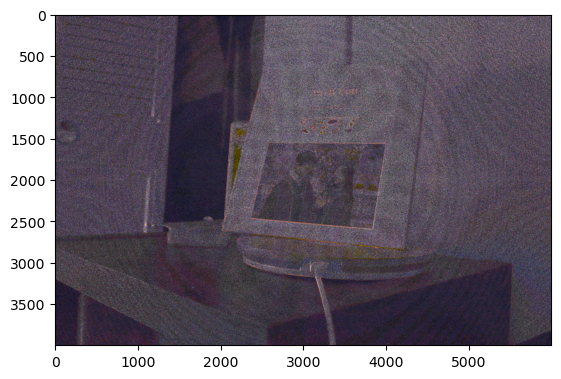

In [28]:
# lambda_val = 0.01
# sigma_s = 32
# sigma_r = 0.15

img_diff_base = np.abs(np.clip(A_base, 0,1) - img_lamp_amb_norm)
# img_diff_base = (img_diff_base - np.min(img_diff_base))/(np.max(img_diff_base) - np.min(img_diff_base))

print(img_diff_base.min(), img_diff_base.max())
plt.imshow(50*img_diff_base)

## Implement joint-bilateral filtering

In [29]:
# Set hyperparameters for bilateral filtering
lambda_val = 0.01
sigma_r = 0.25
# sigma_s = 100
sigma_s = 32


# Calculate minimum and maximum intensity values for the flash image
min_intensity = np.min(img_lamp_flash_norm) - lambda_val
max_intensity = np.max(img_lamp_flash_norm) + lambda_val

# Calculate the number of segments for the bilateral filter
num_segments = np.ceil((max_intensity - min_intensity) / sigma_r).astype('int')

# Generate array of intensity values for each segment
i_j_values = [min_intensity + j * (max_intensity - min_intensity) / num_segments for j in range(num_segments + 1)]

# Set the kernel size for the Gaussian blur
kernel_size = [5, 5]

# Initialize an empty array to store the filtered channels
A_NR = np.zeros_like(img_lamp_amb_norm)

# Apply Piecewise Bilateral filtering to each color channel (R, G, B)
for channel in range(3):
    A_NR[:, :, channel] = piecewise_bilateral(
        img_lamp_amb_norm[:, :, channel], 
        img_lamp_flash_norm[:, :, channel], 
        i_j_values, 
        sigma_r, 
        sigma_s, 
        num_segments, 
        kernel_size
    )

# # Display the final denoised image
# plt.imshow(np.clip(A_NR, 0, 1))
# plt.show()

# Uncomment the following lines if you want to save the image
# plt.imsave(f'outputs/J_sr_{sigma_r}_ss_{sigma_s}_ks_{kernel_size[0]}.png', np.clip(A_NR, 0, 1))

plt.imsave('outputs/A_NR_{}.png'.format(sigma_r), A_NR)

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


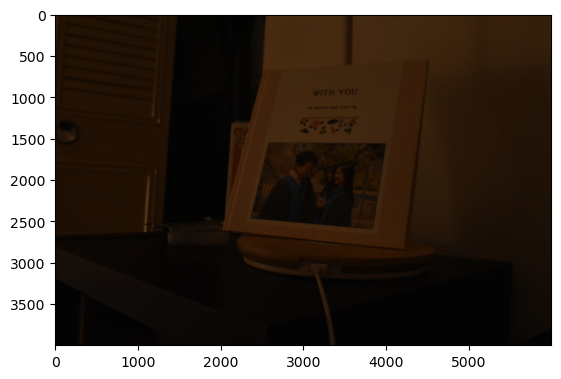

In [30]:
# Display the final denoised image
plt.imshow(np.clip(A_NR, 0, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


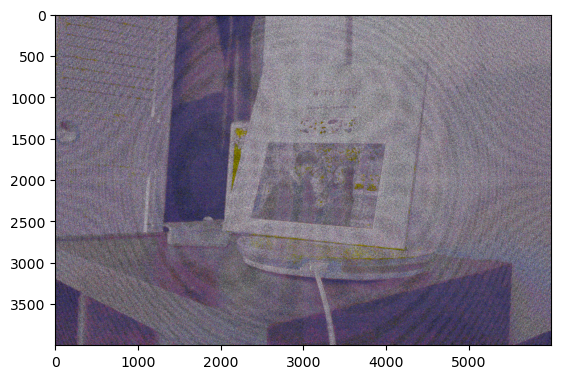

In [31]:
# lambda_val = 0.01
# sigma_s = 32
# sigma_r = 0.15

img_diff_NR = np.abs(np.clip(A_NR, 0,1) - img_lamp_amb_norm)

plt.imshow(100*img_diff_NR)

## Implement detail transfer

100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


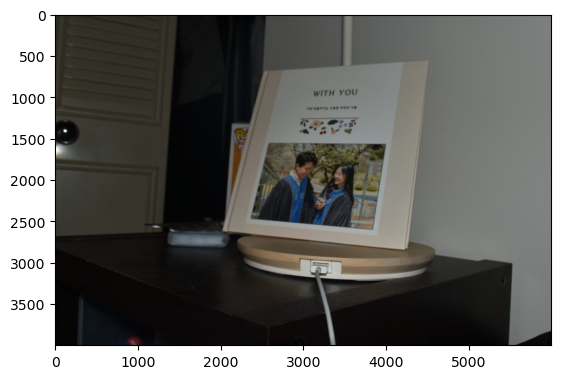

In [32]:
# Set hyperparameters for bilateral filtering
lambda_val = 0.01
sigma_r = 0.25
sigma_s = 32

# Calculate minimum and maximum intensity values for the flash image
min_intensity = np.min(img_lamp_flash_norm) - lambda_val
max_intensity = np.max(img_lamp_flash_norm) + lambda_val

# Calculate the number of segments for the bilateral filter
num_segments = np.ceil((max_intensity - min_intensity) / sigma_r).astype('int')

# Generate array of intensity values for each segment
i_j_values = [min_intensity + j * (max_intensity - min_intensity) / num_segments for j in range(num_segments + 1)]

# Set the kernel size for the Gaussian blur
kernel_size = [11, 11]

# Initialize an empty array to store the filtered channels
F_base = np.zeros_like(img_lamp_flash_norm)

# Apply Piecewise Bilateral filtering to each color channel (R, G, B)
for channel in range(3):
    F_base[:, :, channel] = piecewise_bilateral(
        img_lamp_flash_norm[:, :, channel], 
        img_lamp_flash_norm[:, :, channel], 
        i_j_values, 
        sigma_r, 
        sigma_s, 
        num_segments, 
        kernel_size
    )

# Display the final denoised image
plt.imshow(np.clip(F_base, 0, 1))
plt.show()


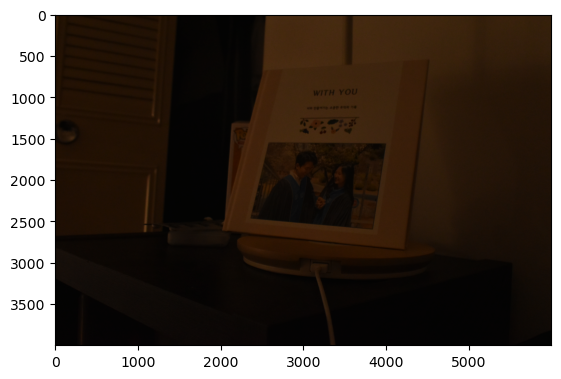

In [33]:
# Apply detail transfer
eps = 0.001
A_Detail = A_NR * (img_lamp_flash_norm + eps) / (F_base + eps)

plt.imshow(np.clip(A_Detail, 0,1))

# plt.imsave('outputs/A_Detail_{}.png'.format(sigma_r), np.clip(A_Detail, 0,1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


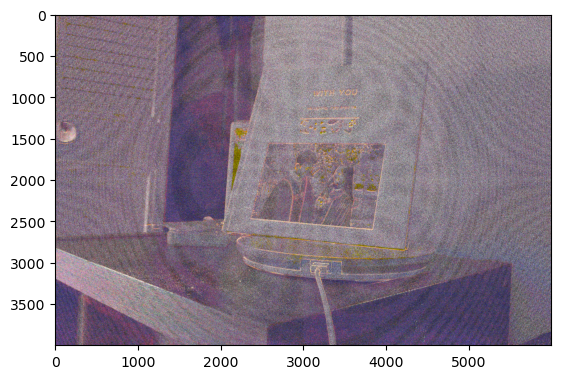

In [34]:
# lambda_val = 0.01
# sigma_s = 32
# sigma_r = 0.05

img_diff_Detail = np.abs(np.clip(A_Detail, 0,1) - img_lamp_amb_norm)

plt.imshow(100*img_diff_Detail)

## Implement shadow and specularity masking

In [35]:
# Function to linearize images
@np.vectorize
def linearize_image(C_nonlinear):
    if C_nonlinear <= 0.0404482:
        return C_nonlinear / 12.92
    else:
        return ((C_nonlinear + 0.055) ** 2.4) / (1.055 ** 2.4)

# Linearize and normalize the images
lamp_amb_norm_lin = linearize_image(img_lamp_amb_norm)
lamp_flash_norm_lin = linearize_image(img_lamp_flash_norm)

# ISO correction (ISO 100 for flash image, ISO 1600 for ambient image)
lamp_amb_norm_lin *= (100 / 1600)

# Initialize shadow and speckle thresholds
shadow_threshold = 0.0005
speckle_threshold = 0.9

# Compute luminance for both images
luminance_amb = cv2.cvtColor(lamp_amb_norm_lin[:, :, ::-1].astype('float32'), cv2.COLOR_BGR2YCR_CB)[:, :, 0]
luminance_flash = cv2.cvtColor(lamp_flash_norm_lin[:, :, ::-1].astype('float32'), cv2.COLOR_BGR2YCR_CB)[:, :, 0]

# Compute shadow map
shadow_map = np.zeros(luminance_amb.shape)
shadow_map[np.abs(luminance_flash - luminance_amb) <= shadow_threshold] = 1

# Compute speckle map
speckle_map = np.zeros(luminance_amb.shape)
speckle_map[luminance_flash > speckle_threshold] = 1

# Morphological operations kernels
opening_kernel = np.ones((3, 3), np.uint8)
closing_kernel = np.ones((8, 8), np.uint8)
dilation_kernel = np.ones((20, 20), np.uint8)

# Apply morphological operations to shadow and speckle maps
shadow_map = cv2.morphologyEx(cv2.morphologyEx(shadow_map, cv2.MORPH_OPEN, opening_kernel), cv2.MORPH_CLOSE, closing_kernel)
speckle_map = cv2.morphologyEx(cv2.morphologyEx(speckle_map, cv2.MORPH_OPEN, opening_kernel), cv2.MORPH_CLOSE, closing_kernel)

# Dilation
shadow_map = cv2.dilate(shadow_map, dilation_kernel)
speckle_map = cv2.dilate(speckle_map, dilation_kernel)

# Combine shadow and speckle maps
final_map = shadow_map.copy()
final_map[speckle_map == 1] = 1

# Apply Gaussian blur to the final map
final_map = cv2.GaussianBlur(final_map, (21, 21), 75)

# Mask-assisted merge
final_map_3channel = np.repeat(final_map[:, :, np.newaxis], 3, axis=2)
A_final = (1 - final_map_3channel) * A_Detail + final_map_3channel * A_base



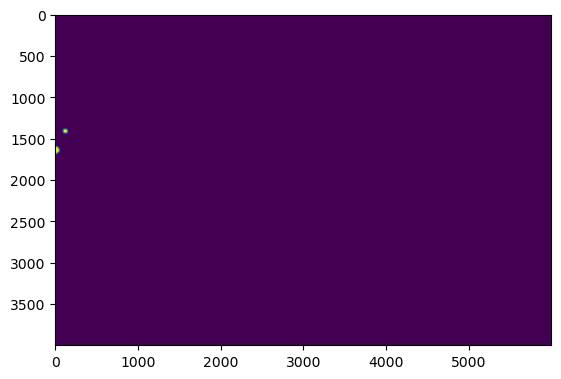

In [36]:
plt.imshow(final_map)

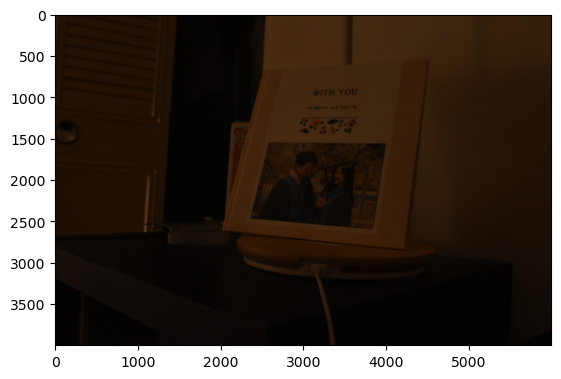

In [37]:
# Display the final image
plt.imshow(np.clip(A_final, 0, 1))
plt.show()


In [38]:
plt.imsave('outputs/A_final_{}_my.png'.format(sigma_r), np.clip(A_final, 0,1))